In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
# import plotly_express as px
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import plotly.graph_objs as go
%matplotlib inline

In [3]:
# Import et aperçu des datasets
df_2024_Table = pd.read_excel("F:\DATA\Datascientest\Projet - Analyse du bien etre\Git-Analyse_du_bien_etre\DataForTable2.1.xls")
df_continents = pd.read_csv("F:\DATA\Datascientest\Projet - Analyse du bien etre\Git-Analyse_du_bien_etre\continents2.csv")

display(df_2024_Table.head())
display(df_continents.head())

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.723590,7.350416,0.450662,50.500000,0.718114,0.164055,0.881686,0.414297,0.258195
1,Afghanistan,2009,4.401778,7.508646,0.552308,50.799999,0.678896,0.187297,0.850035,0.481421,0.237092
2,Afghanistan,2010,4.758381,7.613900,0.539075,51.099998,0.600127,0.117861,0.706766,0.516907,0.275324
3,Afghanistan,2011,3.831719,7.581259,0.521104,51.400002,0.495901,0.160098,0.731109,0.479835,0.267175
4,Afghanistan,2012,3.782938,7.660506,0.520637,51.700001,0.530935,0.234157,0.775620,0.613513,0.267919


,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


________________________________

## Nettoyage des données

In [4]:
# Correspondance des noms de pays
df_2024_Table['Country name'] = df_2024_Table['Country name'].replace({'Türkiye':'Turkey',
                                                                       'Taiwan Province of China':'Taiwan',
                                                                       'Hong Kong S.A.R. of China':'Hong Kong'
                                                                       })

df_continents['name'] = df_continents['name'].replace({'Bosnia And Herzegovina':'Bosnia and Herzegovina',
                                                       'Congo (Democratic Republic Of The)':'Congo (Brazzaville)',
                                                       'Congo':'Congo (Kinshasa)',
                                                       "Côte D'Ivoire":'Ivory Coast',
                                                       'Czech Republic':'Czechia',
                                                       'Macedonia':'North Macedonia',
                                                       'Palestine, State of':'State of Palestine'
                                                       })

# Merge des 2 datasets
df_2024 = pd.merge(df_2024_Table, df_continents[['name', 'region','sub-region']], left_on = "Country name", right_on = "name", how = 'left')

# Drop colonne "name"
df_2024.drop(columns='name', inplace=True)

# Ordre et casse des colonnes
df_2024 = df_2024[['Country name', 'region', 'sub-region'] + [col for col in df_2024.columns if col not in ['Country name', 'region', 'sub-region']]]

df_2024 = df_2024.rename(columns={'region': 'Region', 'sub-region': 'Sub region', 'year': 'Year'})

# Ajout données Kosovo
df_2024.loc[df_2024['Country name'] == 'Kosovo', ['Region', 'Sub region']] = ['Europe', 'Southern Europe']

# Conservation des 10 dernières années 
df_2024 = df_2024.drop(df_2024[df_2024.Year < 2014].index)

## Modélisation

#### Préprocessing

##### Import des packages

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

##### Préparation des données

In [6]:
# Drop des colonnes  Country name, Region et Sub region
df = df_2024.drop(['Year', 'Country name', 'Region', 'Sub region'], axis = 1)

In [7]:
# Séparation en deux dataframe

feats = df.drop('Life Ladder', axis=1)
target = df['Life Ladder']


# Séparation en données d'entrainement et de test

X_train, X_test, y_train, y_test = train_test_split(feats, target, test_size=0.2)


In [8]:
df.isna().sum()

Life Ladder                          0
Log GDP per capita                  22
Social support                       5
Healthy life expectancy at birth    35
Freedom to make life choices        20
Generosity                          30
Perceptions of corruption           77
Positive affect                     10
Negative affect                      9
dtype: int64

In [9]:
df.isna().any(axis=1).sum()

136

In [10]:
# Gestion valeurs manquantes

imputer = SimpleImputer(missing_values=np.nan, strategy='median')

X_train = imputer.fit_transform(X_train)

X_test = imputer.transform(X_test)

print(np.isnan(X_train).sum()) 
print(np.isnan(X_test).sum()) 

0
0


In [11]:
display(X_train.shape)
display(X_test.shape)

(1099, 8)

(275, 8)

#### Linear Regression

In [12]:
# Normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Vérification de la présence de NaN
print(np.isnan(X_train_scaled).sum())
print(np.isnan(X_test_scaled).sum())  


0
0


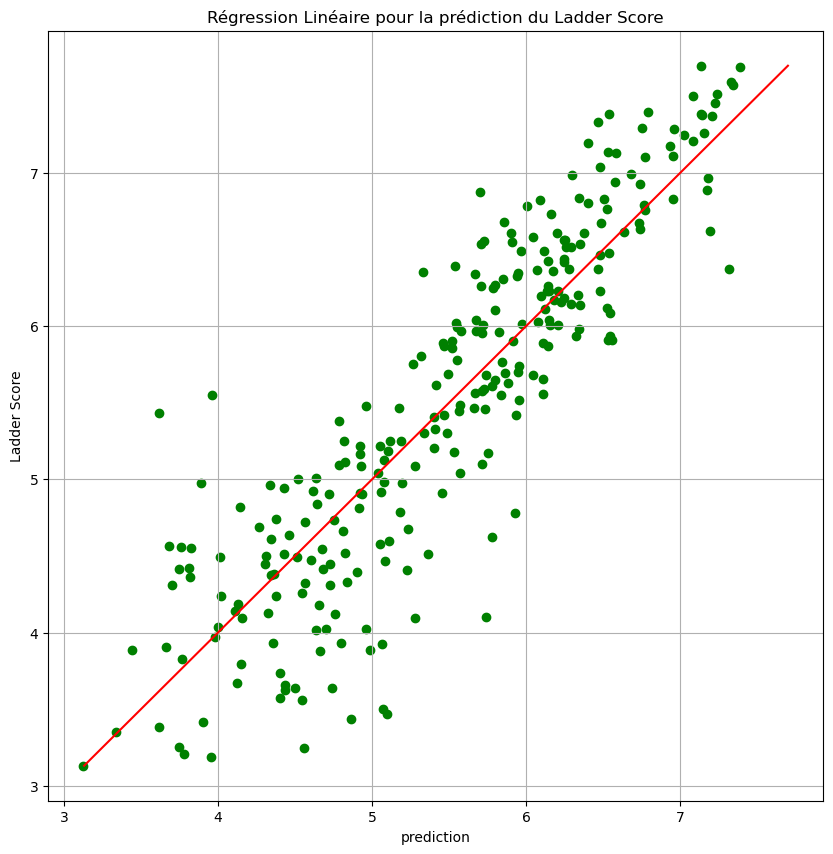

In [13]:
# initialisation et fit du modèle Linear Regressor
lr = LinearRegression()

lr.fit(X_train, y_train)

# visualisation

fig = plt.figure(figsize = (10,10))
pred_test = lr.predict(X_test)
plt.scatter(pred_test, y_test, c='green')

plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), color = 'red')
plt.xlabel("prediction")
plt.ylabel("Ladder Score")
plt.grid()
plt.title('Régression Linéaire pour la prédiction du Ladder Score');

In [14]:
print(lr.intercept_)

print(lr.coef_[0])

-3.717270254978426
0.28660112811766636


In [15]:
# Prédictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Scores d'entraînement et de test
train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)
print(f"Training Score (R²): {train_score}")
print(f"Test Score (R²): {test_score}")

# Calcul des autres métriques
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

Training Score (R²): 0.7857124406777898
Test Score (R²): 0.7874745638725525
Mean Absolute Error: 0.39685443811370513
Mean Squared Error: 0.2684999499281237
Root Mean Squared Error: 0.5181698080051786
R² Score: 0.7874745638725525


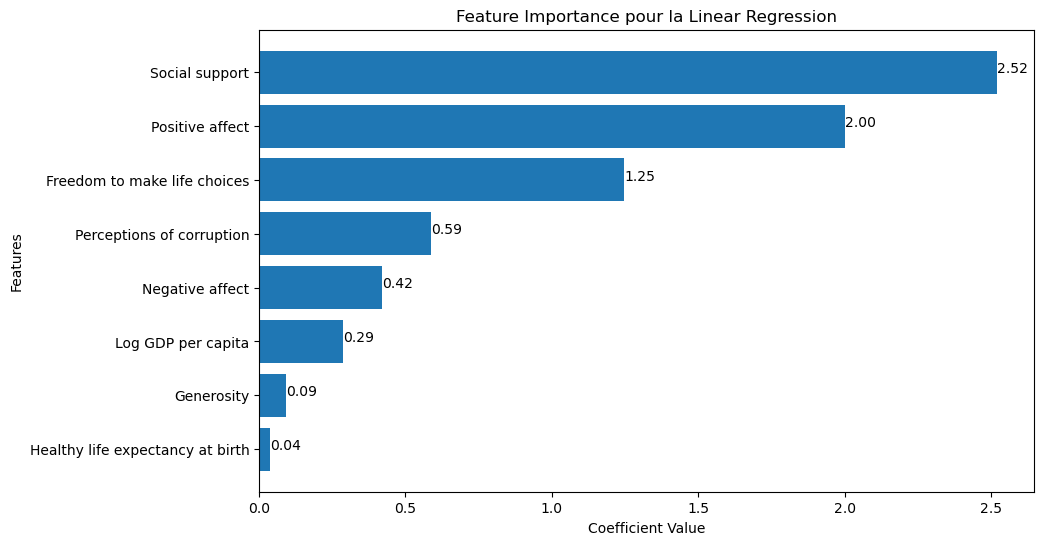

In [16]:
X_train_df = pd.DataFrame(X_train, columns=feats.columns)

feature_importance = pd.DataFrame(np.abs(lr.coef_), index=X_train_df.columns, columns=['importance']).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance.index, feature_importance['importance'])
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title('Feature Importance pour la Linear Regression')
plt.gca().invert_yaxis() 

for index, value in enumerate(feature_importance['importance']):
    plt.text(value, index, f'{value:.2f}')

plt.show()


#### Random Forest Regressor

In [17]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

print(rf.score(X_train,y_train))
print(rf.score(X_test,y_test))

0.983440087145503
0.8735001481966311


In [18]:
# Prédictions
y_pred = rf.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")


Mean Absolute Error: 0.2947143760724501
Mean Squared Error: 0.15981712351245958
R² Score: 0.8735001481966311


In [19]:
# Prédictions sur l'ensemble d'entraînement et de test
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

# Scores d'entraînement et de test
train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)
print(f"Training Score (R²): {train_score}")
print(f"Test Score (R²): {test_score}")

# Calcul des autres métriques
mae = mean_absolute_error(y_test, y_test_pred)
mse = mean_squared_error(y_test, y_test_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_test_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

Training Score (R²): 0.983440087145503
Test Score (R²): 0.8735001481966311
Mean Absolute Error: 0.2947143760724501
Mean Squared Error: 0.15981712351245958
Root Mean Squared Error: 0.39977133903327733
R² Score: 0.8735001481966311


In [20]:
# feature importance
X_train_df = pd.DataFrame(X_train, columns=feats.columns)

feature_importance = pd.DataFrame(rf.feature_importances_, index = X_train_df.columns, columns=['importance']).sort_values('importance', ascending=False)

feature_importance

,importance
Log GDP per capita,0.504809
Social support,0.159542
Healthy life expectancy at birth,0.121767
Positive affect,0.085578
Freedom to make life choices,0.058518
Negative affect,0.026913
Perceptions of corruption,0.022140
Generosity,0.020734


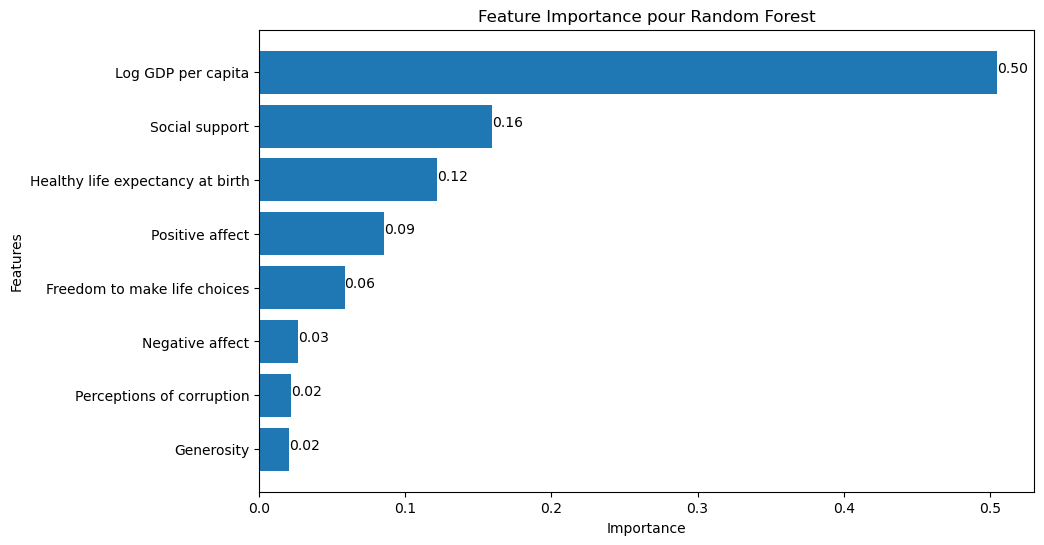

In [21]:
plt.figure(figsize=(10, 6))
plt.barh(feature_importance.index, feature_importance['importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance pour Random Forest')
plt.gca().invert_yaxis()

for index, value in enumerate(feature_importance['importance']):
    plt.text(value, index, f'{value:.2f}')

plt.show()


#####  Hyper parameter

In [29]:
from sklearn.model_selection import GridSearchCV

max_features_range = np.arange(1,6,1)
n_estimators_range = np.arange(10,200,10)
param_grid = dict(max_features=max_features_range, n_estimators=n_estimators_range)

rf = RandomForestRegressor()

grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

In [30]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': array([1, 2, 3, 4, 5]),
                         'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])})

In [31]:
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

The best parameters are {'max_features': 4, 'n_estimators': 190} with a score of 0.88
